In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import time
from datetime import timedelta, datetime
import gdown



In [2]:
#DOWNLOADING THE DATASET THROUGH DRIVE LINK TO COLAB CLOUD
file_id = "1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9"
url = f"https://drive.google.com/uc?id={file_id}"
output = "cic_custom.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9
From (redirected): https://drive.google.com/uc?id=1CQ2Y9wcz_1EG47B4QwVcIrfwyjiUX7H9&confirm=t&uuid=1ca0a269-8c51-4abe-9389-78d37bfe87c9
To: /content/cic_custom.csv
100%|██████████| 487M/487M [00:10<00:00, 48.0MB/s]


'cic_custom.csv'

In [3]:
#READING DATASET
t0 = time.monotonic()
df = pd.read_csv(output)
t1 = time.monotonic()
print(f"Loading time: {t1-t0}")
print(df.head())

#LABELS SETTING
dfToReplace = df[['Label_Botnet','Label_Brute-force','Label_DDoS attack','Label_DoS attack','Label_Web attack']]

df['attack'] = dfToReplace.idxmax(axis=1).str.replace('Label_', '')
attacks = df['attack']
mapping = {'Botnet': 0, 'Brute-force':1,'DDoS attack':2, 'DoS attack':3,'Web attack':4}
df['attack'] = df['attack'].replace(mapping)

df = df.drop(['Label_Botnet','Label_Brute-force','Label_DDoS attack','Label_DoS attack','Label_Web attack'], axis=1)

print(df.head())

Loading time: 18.460781886999996
   Dst Port  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0  0.001221       0.285568      0.000003      0.000000         0.000000   
1  0.123293       0.000076      0.000006      0.000033         0.000002   
2  0.000320       0.000000      0.000000      0.000008         0.000000   
3  0.001221       0.086598      0.000003      0.000000         0.000000   
4  0.123293       0.000084      0.000006      0.000033         0.000002   

   Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  Bwd Pkt Len Max  \
0         0.000000              0.0          0.000000         0.000000   
1         0.005058              0.0          0.006576         0.001719   
2         0.000000              0.0          0.000000         0.000000   
3         0.000000              0.0          0.000000         0.000000   
4         0.005058              0.0          0.006576         0.001719   

   Bwd Pkt Len Min  ...  Active Std  Idle Min  Protocol_0  Protocol_6  

<ipython-input-3-5027d074e293>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['attack'] = df['attack'].replace(mapping)


In [4]:
print(df.isnull().sum())
print("DUPLICATED VALUES ",df.duplicated().sum())
#remove duplicared rows values
df = df.drop_duplicates()

Dst Port             0
Flow Duration        0
Tot Fwd Pkts         0
Tot Bwd Pkts         0
TotLen Fwd Pkts      0
Fwd Pkt Len Max      0
Fwd Pkt Len Min      0
Fwd Pkt Len Mean     0
Bwd Pkt Len Max      0
Bwd Pkt Len Min      0
Bwd Pkt Len Mean     0
Flow Byts/s          0
Flow Pkts/s          0
Flow IAT Mean        0
Flow IAT Std         0
Flow IAT Max         0
Bwd IAT Tot          0
Bwd IAT Mean         0
Bwd IAT Std          0
Bwd IAT Max          0
Bwd IAT Min          0
Fwd PSH Flags        0
Fwd URG Flags        0
Bwd Pkts/s           0
Pkt Len Var          0
FIN Flag Cnt         0
SYN Flag Cnt         0
RST Flag Cnt         0
PSH Flag Cnt         0
ACK Flag Cnt         0
URG Flag Cnt         0
CWE Flag Count       0
Down/Up Ratio        0
Subflow Fwd Byts     0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Seg Size Min     0
Active Mean          0
Active Std           0
Idle Min             0
Protocol_0           0
Protocol_6           0
Protocol_17          0
attack     

In [5]:
print("DUPLICATED VALUES ",df.duplicated().sum())


DUPLICATED VALUES  0


In [6]:
#PREPROCESSING AND EDA
t = df['attack']
X = df.drop(['attack'],axis=1)

feature_names = X.columns.tolist()
class_names = ['Botnet', 'Brute-force','DDoS attack', 'DoS attack','Web attack']

from sklearn.model_selection import train_test_split
X_train,X_test,t_train,t_test = train_test_split(X,t,train_size=0.7,random_state=42)


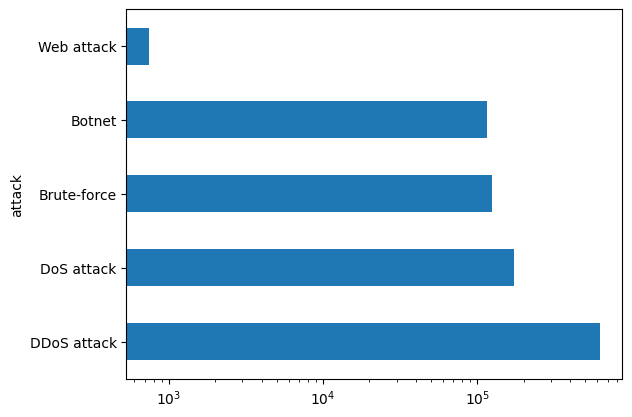

In [7]:
attacks = attacks.value_counts()
attacks.plot(kind='barh')
plt.xscale('log')

In [8]:
bool_cols = [col for col in X if
               df[col].dropna().value_counts().index.isin([0,1]).all()]
X[bool_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fwd PSH Flags,969920.0,0.002009,0.044782,0.0,0.0,0.0,0.0,1.0
Fwd URG Flags,969920.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FIN Flag Cnt,969920.0,0.001093,0.033041,0.0,0.0,0.0,0.0,1.0
SYN Flag Cnt,969920.0,0.002009,0.044782,0.0,0.0,0.0,0.0,1.0
RST Flag Cnt,969920.0,0.492046,0.499937,0.0,0.0,0.0,1.0,1.0
PSH Flag Cnt,969920.0,0.609011,0.487972,0.0,0.0,1.0,1.0,1.0
ACK Flag Cnt,969920.0,0.387458,0.487170,0.0,0.0,0.0,1.0,1.0
URG Flag Cnt,969920.0,0.008442,0.091491,0.0,0.0,0.0,0.0,1.0
CWE Flag Count,969920.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Protocol_0,969920.0,0.000223,0.014921,0.0,0.0,0.0,0.0,1.0


In [9]:
numerical_cols = X.drop(bool_cols, axis=1)
numerical_cols.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Dst Port,969920.0,1.803816e-02,0.060020,0.000000e+00,1.220722e-03,1.220722e-03,1.220722e-03,0.998856
Flow Duration,969920.0,5.825811e-02,0.129104,0.000000e+00,1.384250e-04,7.344379e-03,3.564833e-02,1.000000
Tot Fwd Pkts,969920.0,7.958505e-04,0.018027,0.000000e+00,3.229682e-06,6.459364e-06,6.459364e-06,1.000000
Tot Bwd Pkts,969920.0,3.162168e-05,0.000047,0.000000e+00,0.000000e+00,3.303301e-05,3.303301e-05,0.001016
TotLen Fwd Pkts,969920.0,5.576790e-05,0.001237,0.000000e+00,0.000000e+00,1.385120e-07,2.257745e-06,0.068620
Fwd Pkt Len Max,969920.0,2.333579e-03,0.003131,0.000000e+00,0.000000e+00,3.103181e-04,5.042669e-03,0.022653
Fwd Pkt Len Min,969920.0,1.046739e-04,0.003959,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.342466
Fwd Pkt Len Mean,969920.0,2.404380e-03,0.002989,0.000000e+00,0.000000e+00,4.033878e-04,5.520266e-03,0.042105
Bwd Pkt Len Max,969920.0,7.445861e-03,0.007140,0.000000e+00,0.000000e+00,1.719110e-03,1.479662e-02,0.061581
Bwd Pkt Len Min,969920.0,6.969929e-07,0.000396,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.225342


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#importing models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

Correlation matrix building time 5.895449009999993


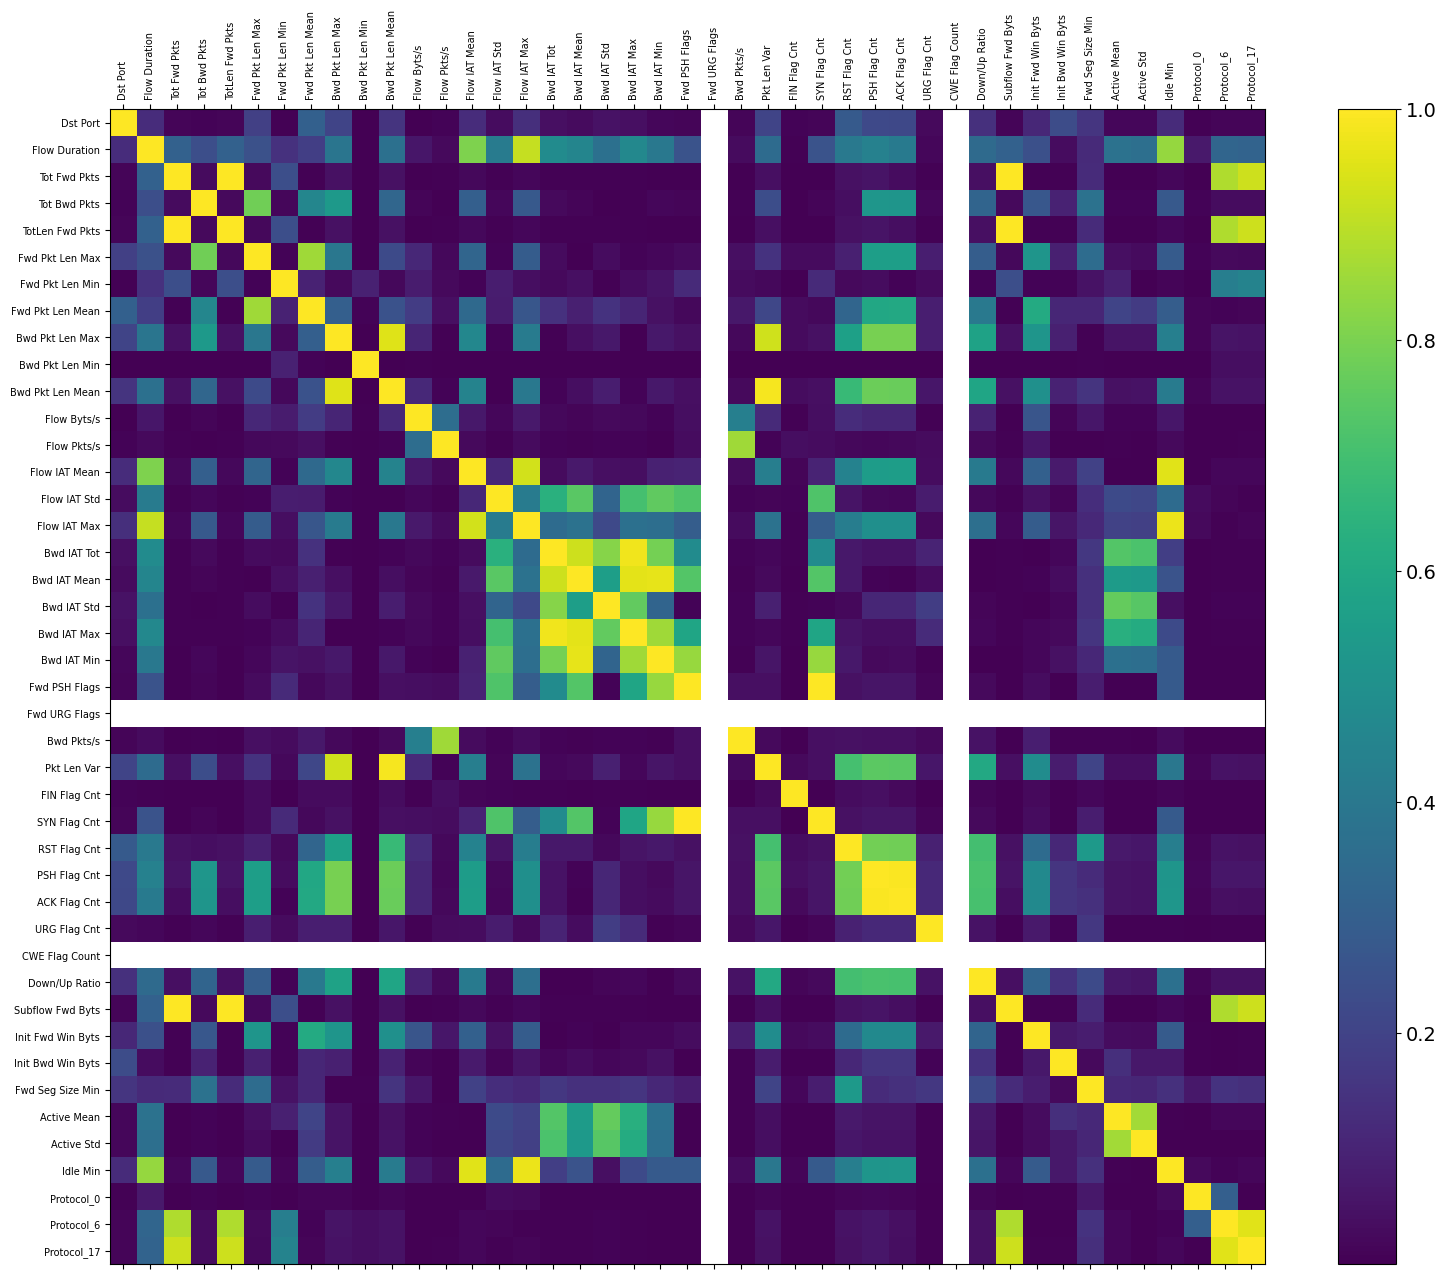

In [12]:
#CORRELATION MATRIX
t0 = time.monotonic()
fig, ax = plt.subplots(figsize=(19, 15))
cax = ax.matshow(abs(X.corr()))


ax.set_xticks(np.arange(X.shape[1]))
ax.set_xticklabels(list(X), fontsize=7, rotation=90)
ax.set_yticks(np.arange(X.shape[1]))
ax.set_yticklabels(list(X), fontsize=7)


cb = fig.colorbar(cax)
cb.ax.tick_params(labelsize=14)

t1 = time.monotonic()
print(f"Correlation matrix building time {t1-t0}")

plt.show()

In [13]:
#PRUNING, SEARCHING FOR THE BEST CCP_ALPHA VALUE

t0 = time.monotonic()
ccp_values=[0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]
clfs = []
for ccp_alpha in ccp_values:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train,t_train)
    test_scores = clf.score(X_train,t_train)
    clfs.append(clf)
    print("Number of nodes in the tree with ccp_alpha {} is {} , depth {} or {}, and score {}".format(ccp_alpha, clf.tree_.node_count,  clf.tree_.max_depth, clf.get_depth(), test_scores )  )
t1 = time.monotonic()

print(f"Pruming time: {t1-t0}")

Number of nodes in the tree with ccp_alpha 0 is 103 , depth 23 or 23, and score 0.9999602323608427
Number of nodes in the tree with ccp_alpha 0.001 is 13 , depth 4 or 4, and score 0.9997260451524721
Number of nodes in the tree with ccp_alpha 0.002 is 11 , depth 4 or 4, and score 0.999052941037847
Number of nodes in the tree with ccp_alpha 0.005 is 11 , depth 4 or 4, and score 0.999052941037847
Number of nodes in the tree with ccp_alpha 0.01 is 9 , depth 3 or 3, and score 0.99861991563369
Number of nodes in the tree with ccp_alpha 0.02 is 7 , depth 2 or 2, and score 0.9978952608757129
Number of nodes in the tree with ccp_alpha 0.03 is 7 , depth 2 or 2, and score 0.9978952608757129
Number of nodes in the tree with ccp_alpha 0.05 is 7 , depth 2 or 2, and score 0.9978952608757129
Pruming time: 78.16727984699997


In [14]:
#DECISION TREE
DT = DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=14, ccp_alpha=0, splitter = 'best')
#Best parameters obtained for Decision tree:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 12, 'splitter': 'best'}
#Obtained with GridsearchCV
t0 =  time.monotonic()
DT.fit(X_train,t_train)
t1 = time.monotonic()

print(f"Decision tree training time: {t1-t0}")

print(DT.score(X_train,t_train))
print(DT.score(X_test,t_test))




Decision tree training time: 9.173065336999969
0.9999587594853184
0.9999209556801936


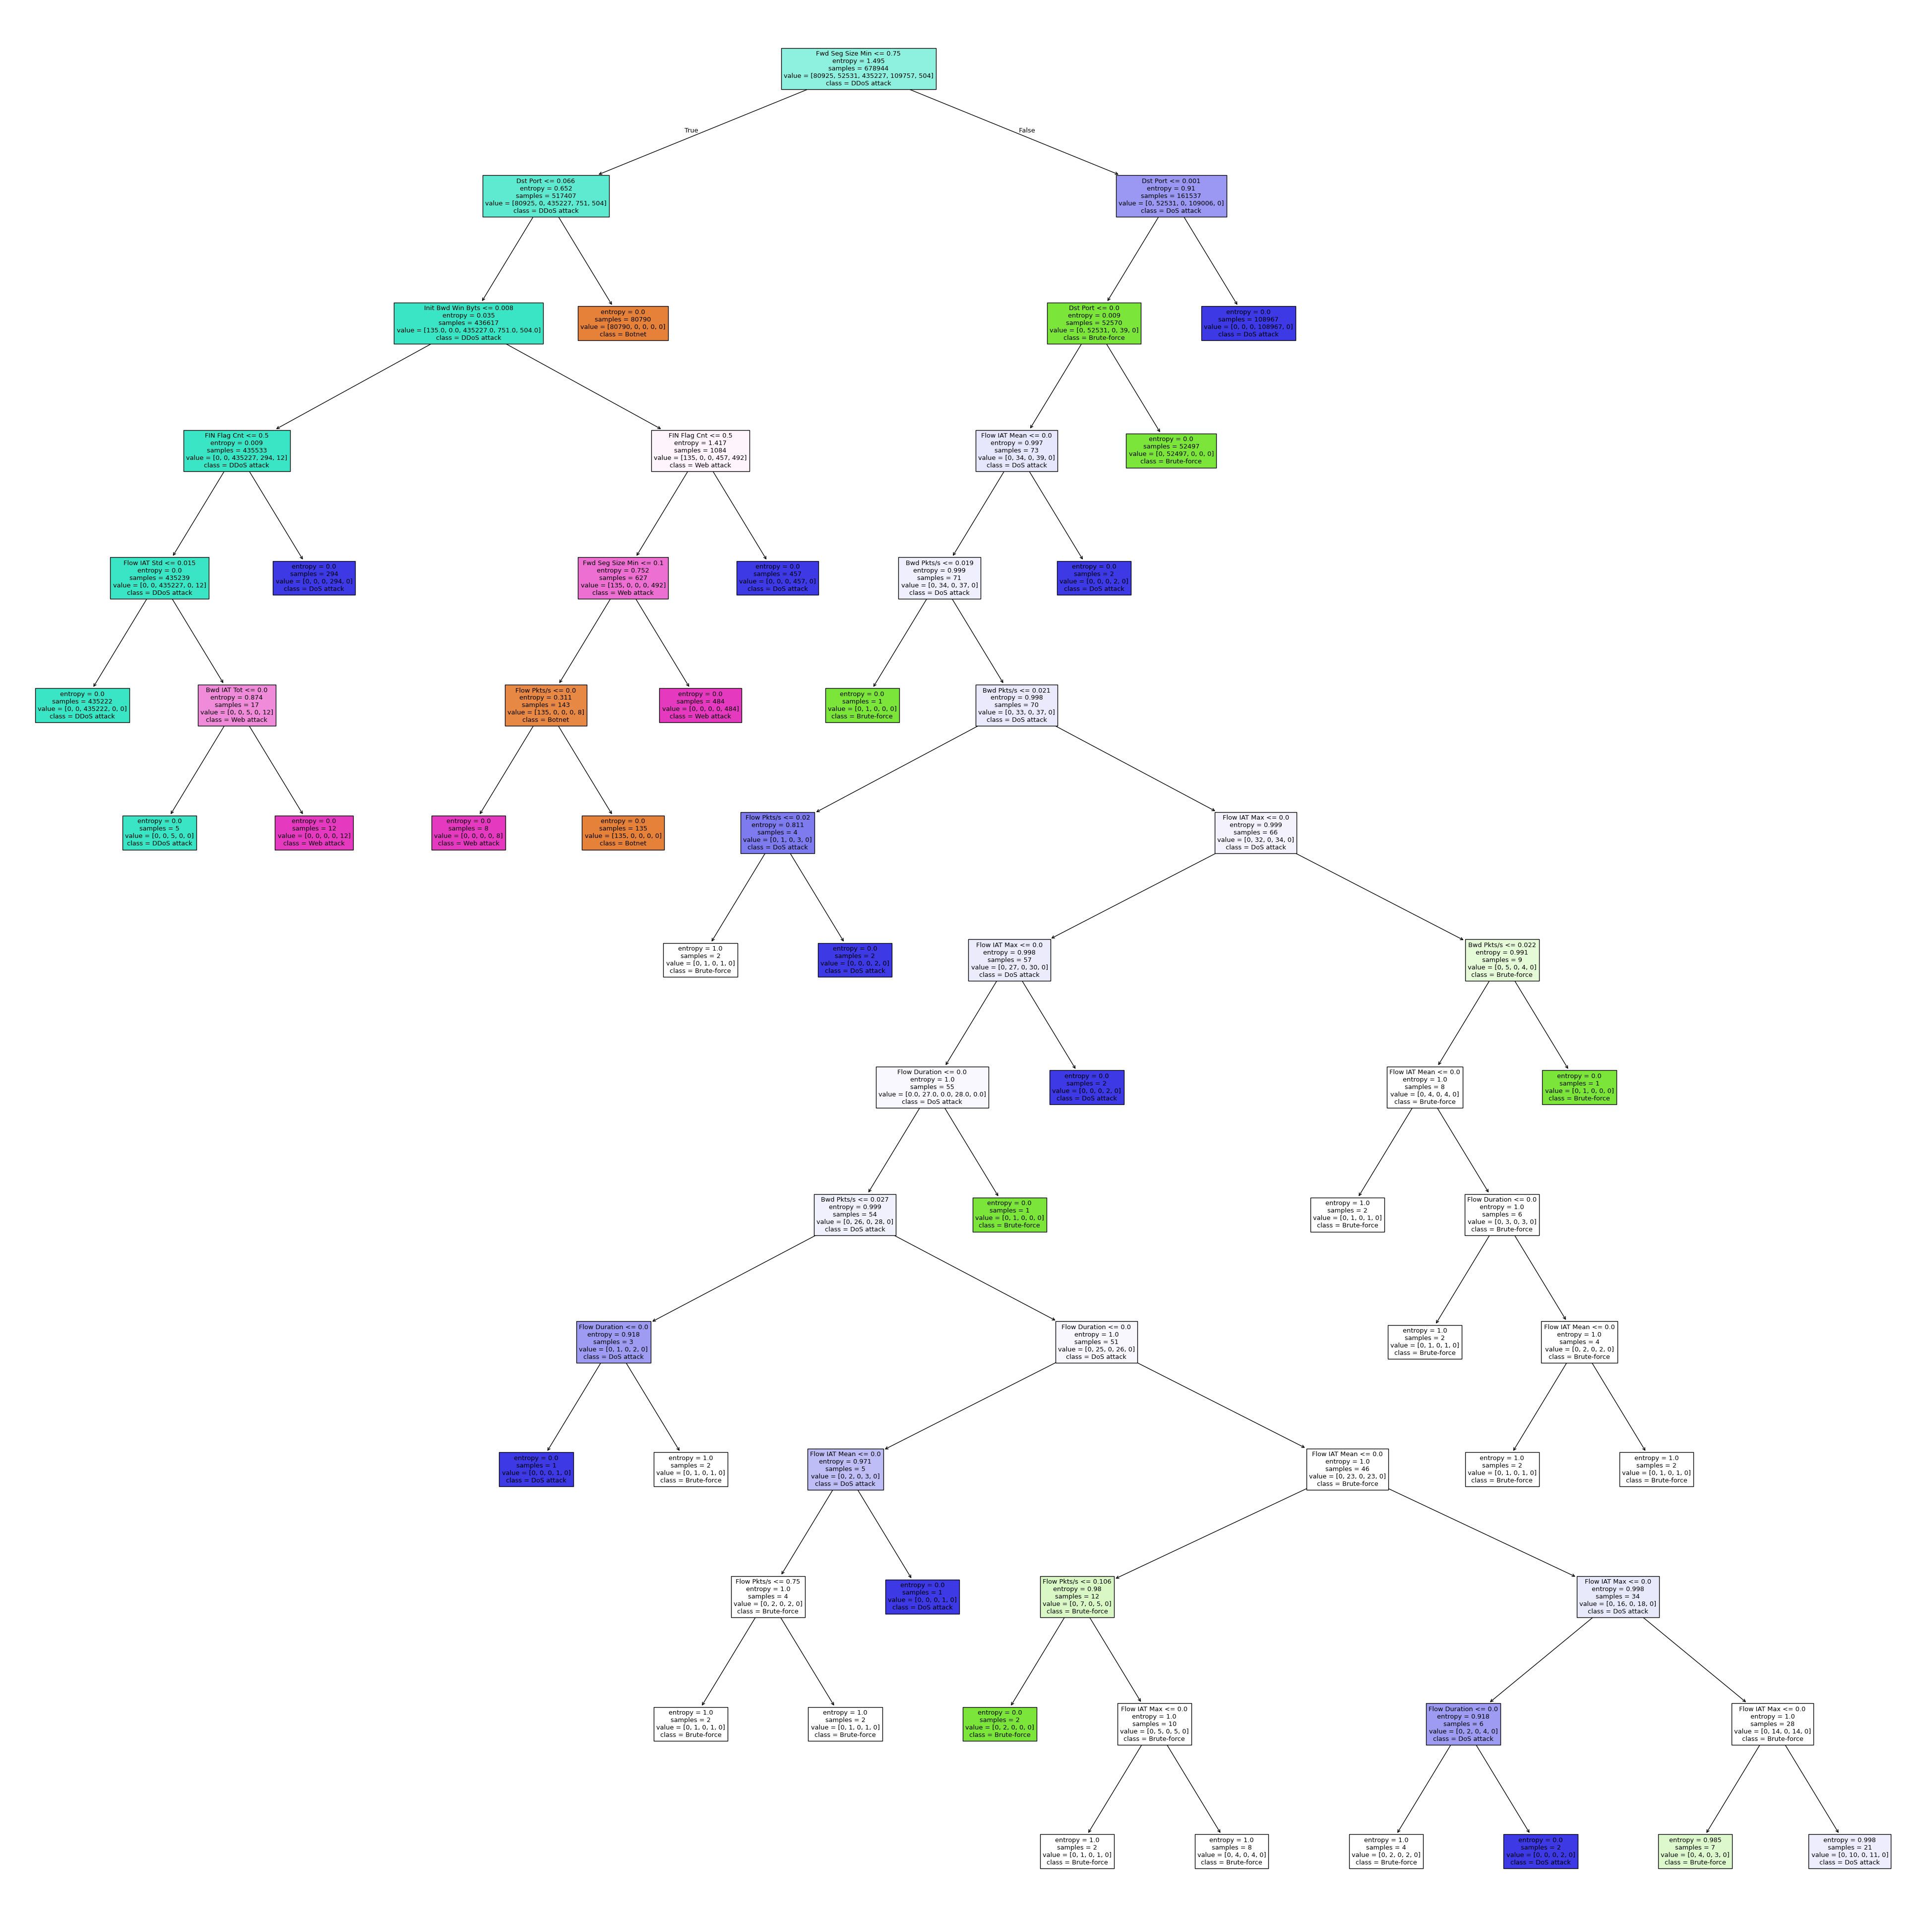

Decision tree plot and show time: 2.549332789999994


In [15]:
#PLOTTING THE TREE
t0 = time.monotonic()
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(DT, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()
t1 = time.monotonic()
print(f"Decision tree plot and show time: {t1-t0}")

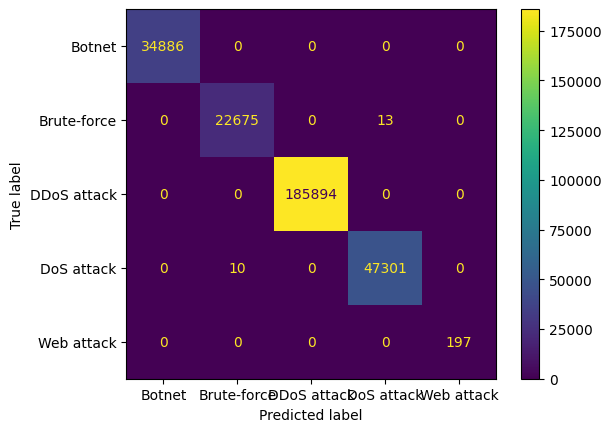

              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00     34886
 Brute-force       1.00      1.00      1.00     22688
 DDoS attack       1.00      1.00      1.00    185894
  DoS attack       1.00      1.00      1.00     47311
  Web attack       1.00      1.00      1.00       197

    accuracy                           1.00    290976
   macro avg       1.00      1.00      1.00    290976
weighted avg       1.00      1.00      1.00    290976



In [20]:
#DECISION TREE PREDICTION SCORES
t_predicted_DT = DT.predict(X_test)
results_pruned = confusion_matrix(t_test,t_predicted_DT)
error_pruned = zero_one_loss(t_test,t_predicted_DT)
disp = ConfusionMatrixDisplay(confusion_matrix=results_pruned, display_labels=class_names)
disp.plot()
plt.show()

print(classification_report(t_test, t_predicted_DT, target_names=class_names))

In [25]:
#RANDOM FOREST
RF = RandomForestClassifier(max_depth = 14,n_estimators=100, criterion='gini', random_state=42)
#best parameters obtained by using GridSearchCV
t0 = time.monotonic()
RF.fit(X_train,t_train)
t1 = time.monotonic()
print(f"Random forest training time: {t1-t0}")

print(RF.score(X_train,t_train))
print(RF.score(X_test,t_test))



Random forest training time: 189.11301031900007
0.9999602323608427
0.9999140822610799


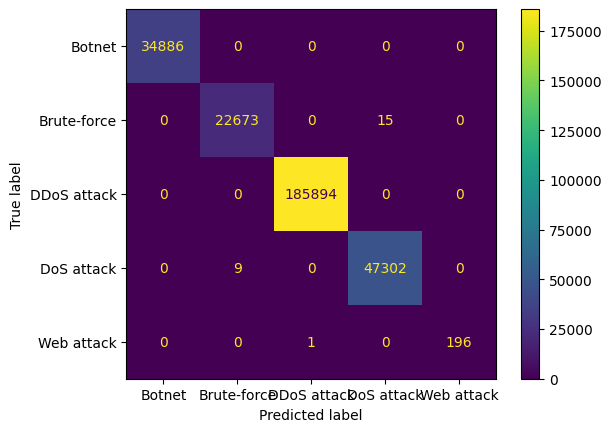

              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00     34886
 Brute-force       1.00      1.00      1.00     22688
 DDoS attack       1.00      1.00      1.00    185894
  DoS attack       1.00      1.00      1.00     47311
  Web attack       1.00      0.99      1.00       197

    accuracy                           1.00    290976
   macro avg       1.00      1.00      1.00    290976
weighted avg       1.00      1.00      1.00    290976



In [28]:
#RANDOM FOREST PREDICTION SCORES
t_predicted_RF = RF.predict(X_test)
results_RF = confusion_matrix(t_test, t_predicted_RF)
disp_RF = ConfusionMatrixDisplay(confusion_matrix=results_RF, display_labels=class_names)
disp_RF.plot()
plt.show()

print(classification_report(t_test, t_predicted_RF, target_names=class_names))

In [19]:
#XGB
XGB = xgb.XGBClassifier(objective="multi:softprob", random_state=42, learning_rate=0.1, max_depth = 10)

t0 = time.monotonic()
XGB.fit(X_train, t_train)
t1 = time.monotonic()
print(f"XGBoost training time: {t1-t0}")

print(XGB.score(X_train,t_train))
print(XGB.score(X_test,t_test))

XGBoost training time: 79.91426178299992
0.9999499222321723
0.9999347025184208


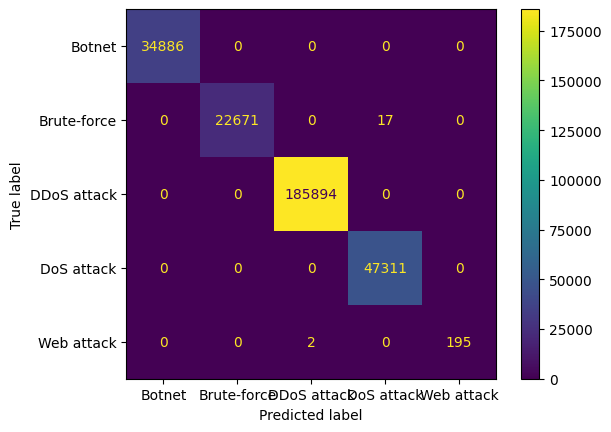

              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00     34886
 Brute-force       1.00      1.00      1.00     22688
 DDoS attack       1.00      1.00      1.00    185894
  DoS attack       1.00      1.00      1.00     47311
  Web attack       1.00      0.99      0.99       197

    accuracy                           1.00    290976
   macro avg       1.00      1.00      1.00    290976
weighted avg       1.00      1.00      1.00    290976



In [27]:
#XGB PREDICTION SCORES
t_predicted_XGB = XGB.predict(X_test)
results_XGB = confusion_matrix(t_test, t_predicted_XGB)
error_XGB = zero_one_loss(t_test, t_predicted_XGB)
disp_XGB = ConfusionMatrixDisplay(confusion_matrix=results_XGB, display_labels=class_names)
disp_XGB.plot()
plt.show()

print(classification_report(t_test, t_predicted_XGB, target_names=class_names))